In [465]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import missingno as msno

In [466]:
race = pd.read_csv("../data/race.csv")
race.info()
runner = pd.read_csv("../data/ultra_rankings.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   race_year_id    1207 non-null   int64  
 1   event           1207 non-null   object 
 2   race            1207 non-null   object 
 3   city            1035 non-null   object 
 4   country         1203 non-null   object 
 5   date            1207 non-null   object 
 6   start_time      1207 non-null   object 
 7   participation   1207 non-null   object 
 8   distance        1207 non-null   float64
 9   elevation_gain  1207 non-null   int64  
 10  elevation_loss  1207 non-null   int64  
 11  aid_stations    1207 non-null   int64  
 12  participants    1207 non-null   int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 122.7+ KB


## Corrections races

### Small Fix

In [467]:
#Renaming Solo to solo
race.loc[race.participation == "Solo", "participation"] = "solo"

In [468]:
#Drop city
#Renaming city ??? to right name

#race.loc[race.race_year_id == 62705, "city"] = "Huanglong"
#race.loc[race.race_year_id == 51649, "city"] = "Keelung"
#race.loc[race.race_year_id == 45523, "city"] = "Keelung"

In [469]:
#Renaming NaN country to right country

race.loc[race.race_year_id == 27391, "country"] = "Israel"
race.loc[race.race_year_id == 11920, "country"] = "Israel"
race.loc[race.race_year_id == 6692, "country"] = "Israel"
race.loc[race.race_year_id == 4710, "country"] = "Israel"

In [470]:
#Distance = 0 => NaN
race.loc[race.distance == 0, "distance"] = np.nan
race.loc[np.logical_and(race.elevation_gain == 0, pd.isna(race.distance) ), "elevation_gain"] = np.nan
race.loc[np.logical_and(race.elevation_loss == 0, pd.isna(race.distance) ), "elevation_loss"] = np.nan

In [471]:
race.loc[race.start_time == "00:00:00", "start_time"] = np.nan

In [472]:
runner = runner.rename(columns={"rank": "ranking"})

In [473]:
runner.loc[runner.age == 0, "age"] = np.nan
runner.loc[runner.age < 16, "age"] = np.nan
runner.loc[runner.age > 100, "age"] = np.nan


### Modification du jeu

In [474]:
race = race.assign( 
    year = race.date.str[:4],
    month = race.date.str[5:7],
    day = race.date.str[8:10]
)
race = race.drop(columns=['date'])

In [475]:
#Import frequency from ranking csv
#race = race.assign( frequency_in_ranking = race['race_year_id'].map(runner['race_year_id'].value_counts()).fillna(0).astype(int) )
race = race.assign( participants = race['race_year_id'].map(runner['race_year_id'].value_counts()).fillna(0).astype(int) )

In [476]:
#Catégorie d'age
age_range_types = pd.CategoricalDtype( 
    categories=['16-25','26-40','40-60','61+','Undefined']
)

runner = runner.assign( age_range = runner.age)
runner.age_range = pd.cut(runner.age_range, bins = [16,25,40,60,100], labels=['16-25','26-40','40-60','61+'])
runner.age_range = runner.age_range.astype(age_range_types)
runner.loc[pd.isna(runner.age_range), "age_range"] = 'Undefined'

In [477]:
A = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
runner = runner.assign(
    speed = A.distance / A.time_in_seconds *3600
)

In [478]:
runner = runner.assign(
    runner_id = runner.runner.str.replace(' ', '') + runner.nationality.str[:] + runner.gender.str[:] + runner.age.astype(str).str[:]
)
runner

,race_year_id,ranking,runner,time,age,gender,nationality,time_in_seconds,age_range,speed,runner_id
0,68140,1.0,VERHEUL Jasper,26H 35M 25S,30.0,M,GBR,95725.0,26-40,6.276730,VERHEULJasperGBRM30.0
1,68140,2.0,MOULDING JON,27H 0M 29S,43.0,M,GBR,97229.0,40-60,6.179638,MOULDINGJONGBRM43.0
2,68140,3.0,RICHARDSON Phill,28H 49M 7S,38.0,M,GBR,103747.0,26-40,5.791396,RICHARDSONPhillGBRM38.0
3,68140,4.0,DYSON Fiona,30H 53M 37S,55.0,W,GBR,111217.0,40-60,5.402412,DYSONFionaGBRW55.0
4,68140,5.0,FRONTERAS Karen,32H 46M 21S,48.0,W,GBR,117981.0,40-60,5.092684,FRONTERASKarenGBRW48.0
...,...,...,...,...,...,...,...,...,...,...,...
137798,3253,42.0,MARR Gary,35H 29M 0S,70.0,M,USA,127740.0,61+,4.537341,MARRGaryUSAM70.0
137799,3253,43.0,SCHOLZ Monica,35H 37M 0S,54.0,W,CAN,128220.0,40-60,4.520356,SCHOLZMonicaCANW54.0
137800,3253,44.0,GRYFE Robert,35H 46M 0S,55.0,M,CAN,128760.0,40-60,4.501398,GRYFERobertCANM55.0
137801,3253,45.0,ESCOBAR Luis James,35H 48M 0S,58.0,M,USA,128880.0,40-60,4.497207,ESCOBARLuisJamesUSAM58.0


<AxesSubplot:>

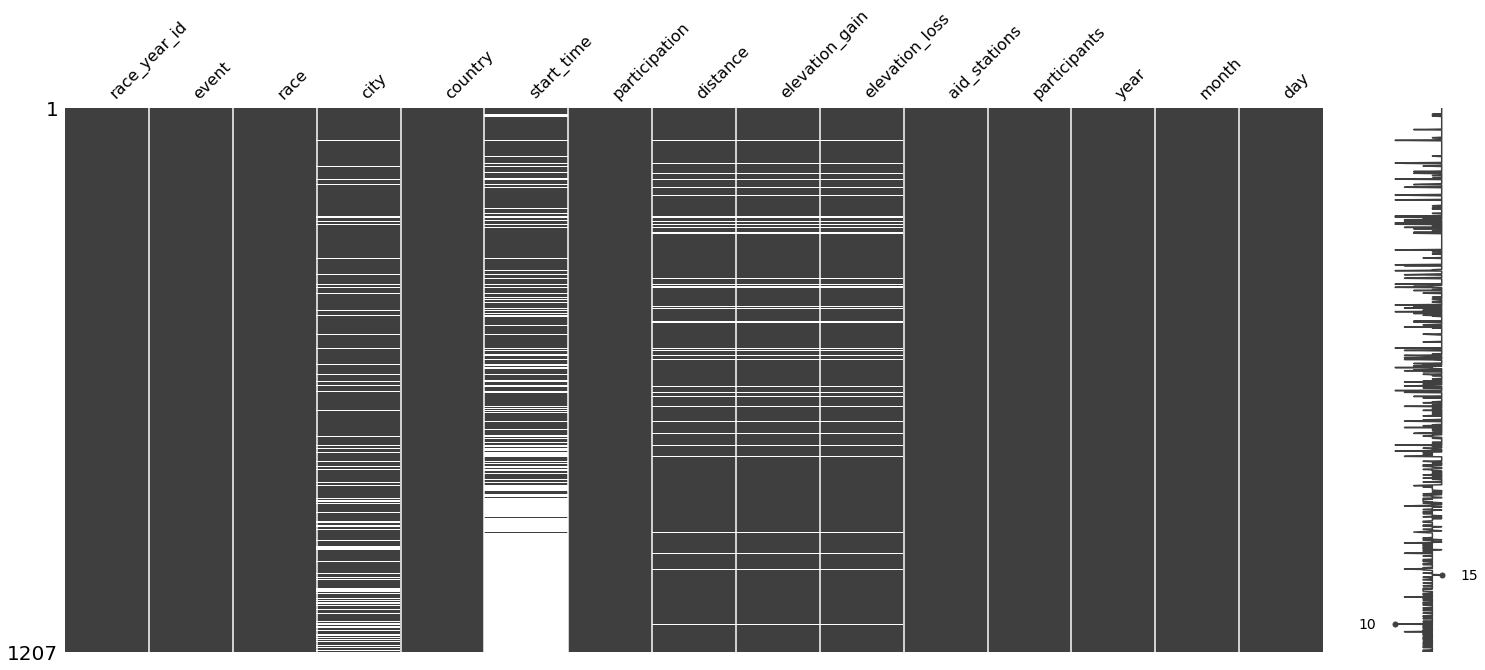

In [479]:
msno.matrix(race)

<AxesSubplot:>

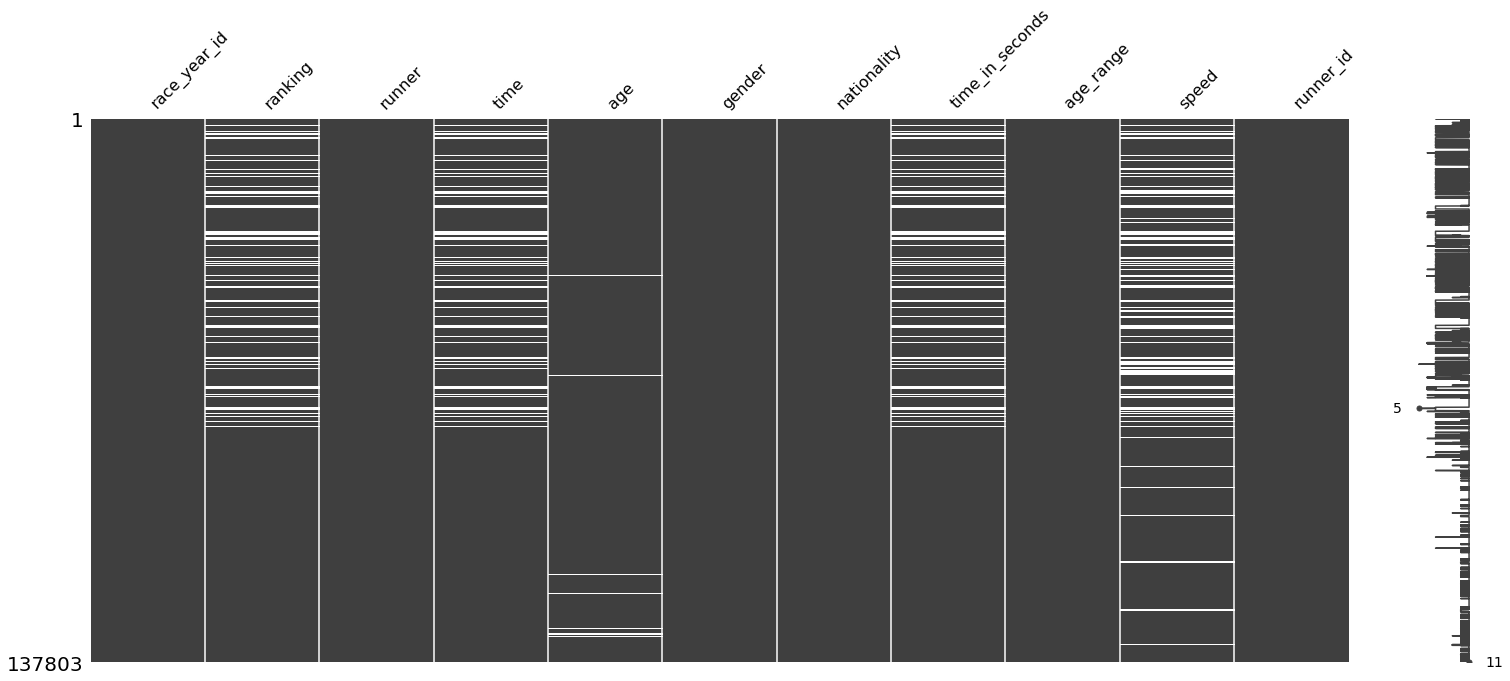

In [480]:
msno.matrix(runner)

Au vu du nombre important de NA (ranking, time), les supprimer des coureurs serait une trop grosse perte d'information. On décide donc de les garder, quitte à les recoder en -1 par la suite pour les méthodes incompatibles.

### Dropping columns

In [481]:
round(race.isna().sum() / len(race) * 100,2)

race_year_id       0.00
event              0.00
race               0.00
city              14.25
country            0.00
start_time        42.50
participation      0.00
distance           6.13
elevation_gain     6.13
elevation_loss     6.13
aid_stations       0.00
participants       0.00
year               0.00
month              0.00
day                0.00
dtype: float64

In [482]:
race = race.drop(columns=['city', 'start_time'])

Remarque:
Les courses n'ayant pas de profil représentent 6%. Les coureurs sur ces courses représentent 5.5% de l'effectif total. On peut donc se permettre de les supprimer au vu du nombre important de données restantes.

In [483]:
id_to_delete = race[pd.isna(race.distance)].race_year_id.to_list()
runner = runner[~runner['race_year_id'].isin(id_to_delete)]

In [484]:
race = race.loc[~pd.isna(race.distance)]

<AxesSubplot:>

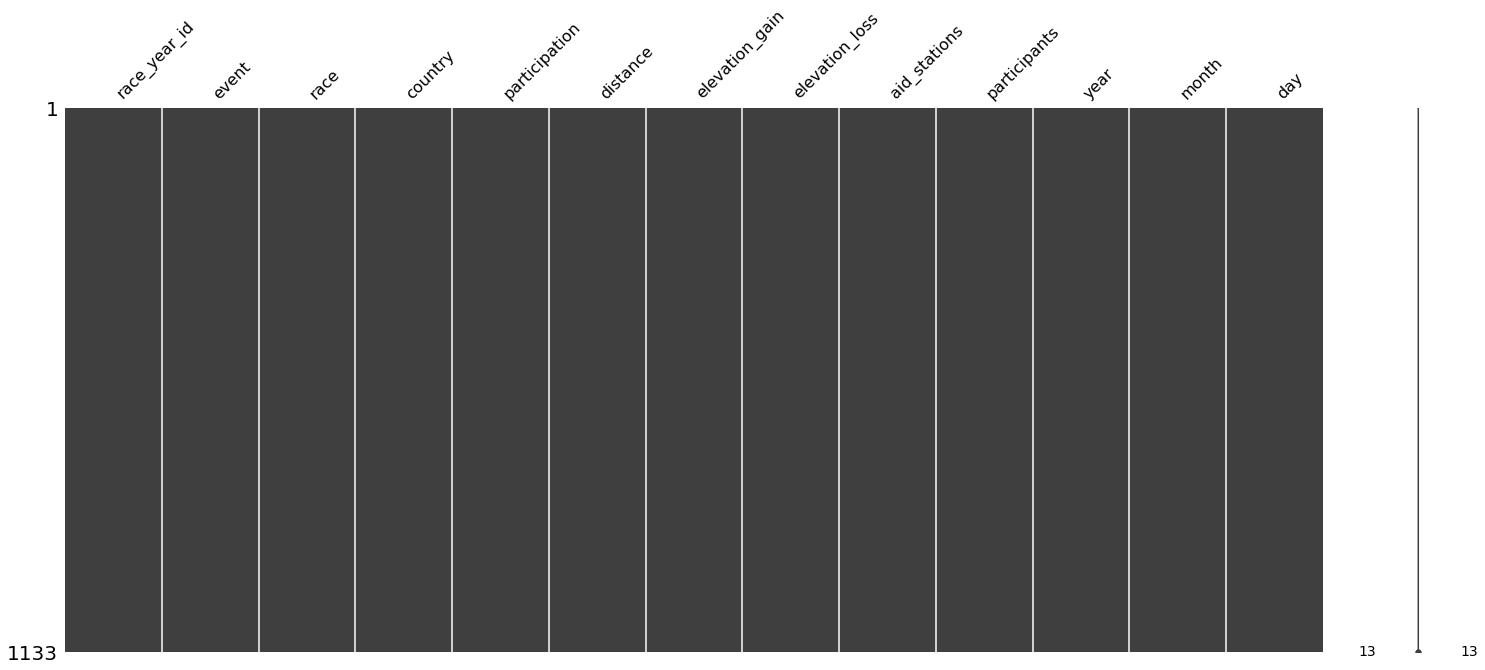

In [485]:
msno.matrix(race)

<AxesSubplot:>

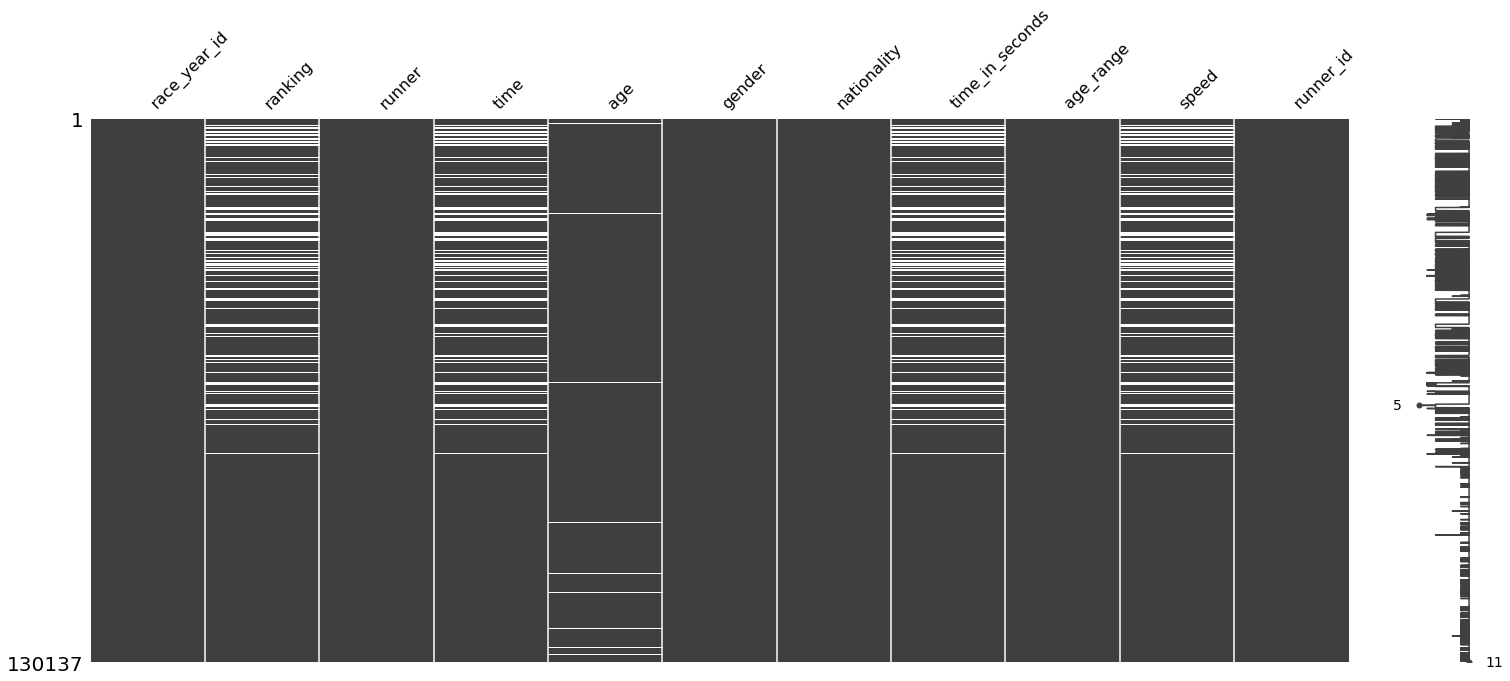

In [486]:
msno.matrix(runner)

In [487]:
from pathlib import Path  

filepath = Path('../output/data_clean/cleaned_race.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

race.to_csv(filepath)  

In [488]:
from pathlib import Path  

filepath = Path('../output/data_clean/cleaned_runner.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

runner.to_csv(filepath)  